## 圖像中的數字辨識

MNIST 訓練及預測：來跑個深度學習界的 ~~hello world~~

---
**【Agenda】**

模型選擇：

*   MLP
*   CNN

比較兩種模型效能：如何比較？


1.   Accuracy
2.   Tensorboard
3.   Confusion matrix


In [1]:
# 下載必要套件
!pip install torchvision

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

In [2]:
# 匯入必要套件

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as Data
import torchvision
import matplotlib.pyplot as plt
from tqdm.notebook import trange, tqdm
import time
#from torchsummary import summary                    # 一樣也要先看看模型建置是否正確
from sklearn import metrics
from torch.utils.tensorboard import SummaryWriter   # 一樣也要用 tensorboard，觀察 torch 訓練過程中的學習曲線

# 創建了兩個 TensorBoard 的日誌寫入器，用於記錄不同模型（MLP 和 CNN）的訓練數據
# 創建一個日誌寫入器並將日誌數據保存到 './runsmlp' 目錄中，用於記錄多層感知機（MLP）的訓練過程
writer_mlp = SummaryWriter('./runsmlp')    # runsmlp, runscnn
# 創建一個日誌寫入器並將日誌數據保存到 './runscnn' 目錄中，用於記錄卷積神經網絡（CNN）的訓練過程
writer_cnn = SummaryWriter('./runscnn')    # runsmlp, runscnn

In [3]:
# 共同參數設定：dataset & others
BATCH_SIZE = 128
LR = 0.001
DOWNLOAD_MNIST = True
EPOCHES = 12

INPUT_DIM = 28 * 28
OUTPUT_DIM = 10

# 就用下載來的 MNIST dataset

train_data = torchvision.datasets.MNIST(
    root = './mnist',
    train = True,
    transform=torchvision.transforms.ToTensor(), #改成torch可讀
    download=DOWNLOAD_MNIST,
)

print(train_data)

# torch 要用 data loader 提供 input data
train_loader = Data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 12548566.95it/s]


Extracting ./mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 343699.04it/s]


Extracting ./mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 3168495.70it/s]


Extracting ./mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 3030628.18it/s]

Extracting ./mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist/MNIST/raw

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./mnist
    Split: Train
    StandardTransform
Transform: ToTensor()


In [4]:
# 測試集也來一下
test_data = torchvision.datasets.MNIST(root='./mnist/', train=False)
print(test_data)

test_loader = Data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=False)


Dataset MNIST
    Number of datapoints: 10000
    Root location: ./mnist/
    Split: Test


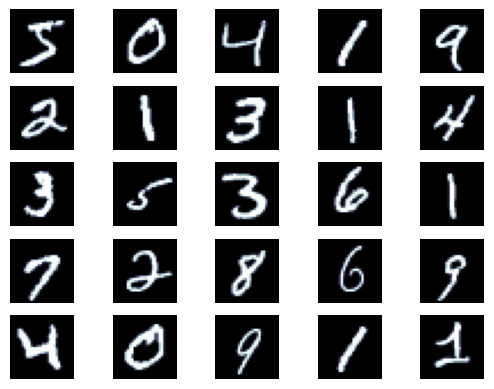

In [5]:
import numpy as np

def plot_images(images):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure()
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        ax.imshow(images[i].view(28, 28).cpu().numpy(), cmap='bone')
        ax.axis('off')

# 可以先看一下圖片的內容
N_IMAGES = 25

images = [image for image, label in [train_data[i] for i in range(N_IMAGES)]]

plot_images(images)


/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


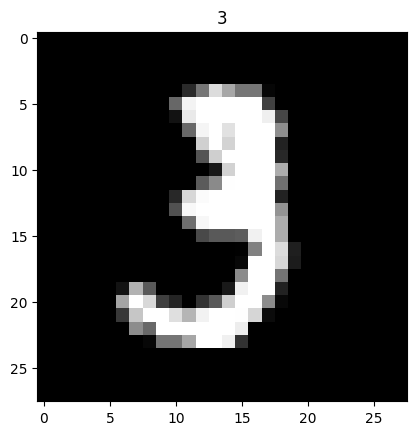

In [6]:
# 對一下圖片和 label / ground truth

IDX_IMAGE = 10  # 要看第幾張圖？
img = np.asarray(train_data.train_data[IDX_IMAGE])
plt.imshow(img, cmap='gray')
plt.title('%i' % train_data.train_labels[IDX_IMAGE])
plt.show()

In [7]:
##### 共用函式 ######################################
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

def train(model, iterator, optimizer, criterion, device, writer):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for (x, y) in tqdm(iterator, desc="Training", leave=False):

        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        y_pred, _ = model(x)

        loss = criterion(y_pred, y)
        writer.add_scalar("Loss/train", loss, epoch)

        acc = calculate_accuracy(y_pred, y)
        writer.add_scalar("Accuracy/train", acc, epoch)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    writer.flush()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():

        for (x, y) in tqdm(iterator, desc="Evaluating", leave=False):

            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

def predict(model, iterator, device):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred, _ = model(x)

            y_prob = F.softmax(y_pred, dim=-1)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim=0)
    labels = torch.cat(labels, dim=0)
    probs = torch.cat(probs, dim=0)

    return images, labels, probs

def plot_confusion_matrix(labels, pred_labels):

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    cm = metrics.confusion_matrix(labels, pred_labels)
    cm = metrics.ConfusionMatrixDisplay(cm, display_labels=range(10))
    cm.plot(values_format='d', cmap='Blues', ax=ax)

## 模型 1 -- Multi-layer Perceptron (MLP)

<img src="http://140.119.164.107/matytest/MLP.png" width=480/>

In [8]:
import torch.nn.functional as F

class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()

        self.input_fc = nn.Linear(input_dim, 250)
        self.hidden_fc = nn.Linear(250, 100)
        self.output_fc = nn.Linear(100, output_dim)

    def forward(self, x):

        # x = [batch size, height, width]

        batch_size = x.shape[0]

        x = x.view(batch_size, -1)

        # x = [batch size, height * width]

        h_1 = F.relu(self.input_fc(x))

        # h_1 = [batch size, 250]

        h_2 = F.relu(self.hidden_fc(h_1))

        # h_2 = [batch size, 100]

        y_pred = self.output_fc(h_2)

        # y_pred = [batch size, output dim]

        return y_pred, h_2



In [9]:
# 建立 MLP 模型

modelMLP = MLP(INPUT_DIM, OUTPUT_DIM)
print(modelMLP)

# 準備其他參數、物件
optimizer_MLP = torch.optim.Adam(modelMLP.parameters())
criterion_MLP = nn.CrossEntropyLoss()

# 看看有沒有 GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
modelMLP = modelMLP.to(device)
criterion_MLP = criterion_MLP.to(device)

# 準備訓練囉？

best_valid_loss = float('inf')

for epoch in trange(EPOCHES):

    start_time = time.monotonic()

    train_loss, train_acc = train(modelMLP, train_loader, optimizer_MLP, criterion_MLP, device, writer_mlp)
    valid_loss, valid_acc = evaluate(modelMLP, test_loader, criterion_MLP, device)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(modelMLP.state_dict(), 'modelMLP.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

MLP(
  (input_fc): Linear(in_features=784, out_features=250, bias=True)
  (hidden_fc): Linear(in_features=250, out_features=100, bias=True)
  (output_fc): Linear(in_features=100, out_features=10, bias=True)
)


  0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 20s
	Train Loss: 0.357 | Train Acc: 90.26%
	 Val. Loss: 0.159 |  Val. Acc: 95.42%


Training:   0%|          | 0/469 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 23s
	Train Loss: 0.132 | Train Acc: 96.00%
	 Val. Loss: 0.092 |  Val. Acc: 97.30%


Training:   0%|          | 0/469 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 14s
	Train Loss: 0.089 | Train Acc: 97.30%
	 Val. Loss: 0.065 |  Val. Acc: 98.04%


Training:   0%|          | 0/469 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 14s
	Train Loss: 0.065 | Train Acc: 97.99%
	 Val. Loss: 0.053 |  Val. Acc: 98.39%


Training:   0%|          | 0/469 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 17s
	Train Loss: 0.050 | Train Acc: 98.45%
	 Val. Loss: 0.034 |  Val. Acc: 98.99%


Training:   0%|          | 0/469 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 15s
	Train Loss: 0.038 | Train Acc: 98.77%
	 Val. Loss: 0.025 |  Val. Acc: 99.27%


Training:   0%|          | 0/469 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 17s
	Train Loss: 0.031 | Train Acc: 99.03%
	 Val. Loss: 0.020 |  Val. Acc: 99.46%


Training:   0%|          | 0/469 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 14s
	Train Loss: 0.025 | Train Acc: 99.25%
	 Val. Loss: 0.018 |  Val. Acc: 99.45%


Training:   0%|          | 0/469 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 14s
	Train Loss: 0.020 | Train Acc: 99.34%
	 Val. Loss: 0.016 |  Val. Acc: 99.52%


Training:   0%|          | 0/469 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 14s
	Train Loss: 0.017 | Train Acc: 99.49%
	 Val. Loss: 0.009 |  Val. Acc: 99.75%


Training:   0%|          | 0/469 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 11 | Epoch Time: 0m 15s
	Train Loss: 0.014 | Train Acc: 99.54%
	 Val. Loss: 0.008 |  Val. Acc: 99.77%


Training:   0%|          | 0/469 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 12 | Epoch Time: 0m 19s
	Train Loss: 0.011 | Train Acc: 99.62%
	 Val. Loss: 0.012 |  Val. Acc: 99.60%


Evaluating:   0%|          | 0/469 [00:00<?, ?it/s]

測試集結果： 0.995985474413646


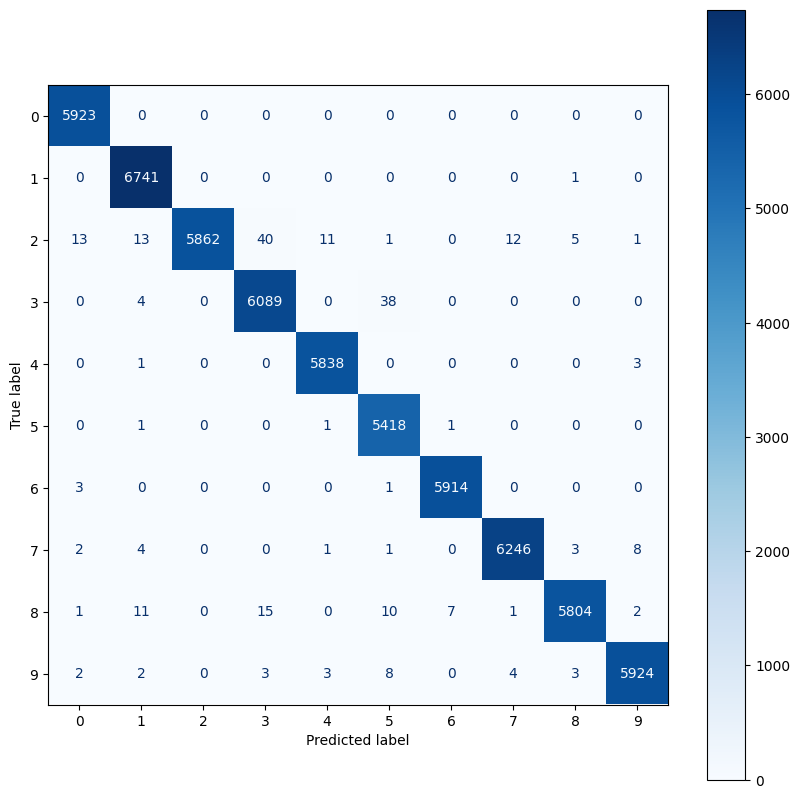

In [10]:
# 用測試資料集，檢查一下 MLP 模型效能
test_loss, test_acc = evaluate(modelMLP, test_loader, criterion_MLP, device)

print('測試集結果：', test_acc)

# 從測試集中，來檢查每個分類的正確程度
images, labels, probs = predict(modelMLP, test_loader, device)

pred_labels = torch.argmax(probs, 1)

# 把結果用 confusion matrix 形式畫出來
plot_confusion_matrix(labels, pred_labels)

## 模型 2 -- Convolutional Neural Network (CNN)

**參考模型：LeNet-5**


<img src="http://140.119.164.107/matytest/lenet-5.jpeg" width=800/>

### 問題 -1 : 卷積層的輸入、輸出維度計算

In [11]:
# 建立 CNN 模型
class CNN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        # C1 + S2
        self.conv1 = nn.Sequential(         # input shape (1, 32, 32)
            nn.Conv2d(                      # output shape (6, 28, 28)
                in_channels=1,              # input height
                out_channels=6,             # n_filters
                kernel_size=5,              # filter size
                stride=1,                   # filter movement/step
                padding=2,
            ),
            nn.Tanh(),                      # activation
            nn.AvgPool2d(kernel_size=2),    # output shape (6, 14, 14)
        )
        # C3 + S4
        self.conv2 = nn.Sequential(         # input shape (6, 14, 14)
            nn.Conv2d(6, 16, 5, 1),         # output shape (16, 10, 10)
            nn.Tanh(),                      # activation
            nn.AvgPool2d(kernel_size=2),    # output shape (16, 5, 5)
        )
        # C5 + FC6
        self.conv3 = nn.Sequential(         # input shape (16, 5, 5)
            nn.Conv2d(16, 120, 5, 1),       # output shape (120, 1, 1)
            nn.Flatten(),
            nn.Linear(120, 84),
        )
        self.out = nn.Linear(84, output_dim)   # fully connected layer, output 10 classes

    def forward(self, x):
        h_conv1 = self.conv1(x)
        h_conv2 = self.conv2(h_conv1)
        h_conv3 = self.conv3(h_conv2)
        h_conv3= h_conv3.view(h_conv3.size(0), -1)           # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        y_pred = self.out(h_conv3)
        return y_pred, h_conv3   # return x for visualization


In [12]:
# 建立 CNN 模型

modelCNN = CNN(INPUT_DIM, OUTPUT_DIM)
print(modelCNN)

# 準備其他參數、物件
optimizer_CNN = torch.optim.Adam(modelCNN.parameters())
criterion_CNN = nn.CrossEntropyLoss()

# 看看有沒有 GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
modelCNN = modelCNN.to(device)
criterion_CNN = criterion_CNN.to(device)



CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (conv2): Sequential(
    (0): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
    (1): Flatten(start_dim=1, end_dim=-1)
    (2): Linear(in_features=120, out_features=84, bias=True)
  )
  (out): Linear(in_features=84, out_features=10, bias=True)
)


In [13]:
# CNN - LeNet5
# 準備訓練囉？

best_valid_loss = float('inf')

for epoch in trange(EPOCHES):

    start_time = time.monotonic()

    train_loss, train_acc = train(modelCNN, train_loader, optimizer_CNN, criterion_CNN, device, writer_cnn)
    valid_loss, valid_acc = evaluate(modelCNN, test_loader, criterion_CNN, device)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(modelCNN.state_dict(), 'modelCNN.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

  0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 17s
	Train Loss: 0.420 | Train Acc: 87.62%
	 Val. Loss: 0.229 |  Val. Acc: 93.11%


Training:   0%|          | 0/469 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 17s
	Train Loss: 0.157 | Train Acc: 95.32%
	 Val. Loss: 0.112 |  Val. Acc: 96.60%


Training:   0%|          | 0/469 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 34s
	Train Loss: 0.099 | Train Acc: 96.97%
	 Val. Loss: 0.102 |  Val. Acc: 96.82%


Training:   0%|          | 0/469 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 27s
	Train Loss: 0.083 | Train Acc: 97.45%
	 Val. Loss: 0.078 |  Val. Acc: 97.59%


Training:   0%|          | 0/469 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 17s
	Train Loss: 0.070 | Train Acc: 97.85%
	 Val. Loss: 0.057 |  Val. Acc: 98.22%


Training:   0%|          | 0/469 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 17s
	Train Loss: 0.059 | Train Acc: 98.16%
	 Val. Loss: 0.059 |  Val. Acc: 98.14%


Training:   0%|          | 0/469 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 18s
	Train Loss: 0.055 | Train Acc: 98.31%
	 Val. Loss: 0.053 |  Val. Acc: 98.41%


Training:   0%|          | 0/469 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 22s
	Train Loss: 0.050 | Train Acc: 98.38%
	 Val. Loss: 0.046 |  Val. Acc: 98.53%


Training:   0%|          | 0/469 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 21s
	Train Loss: 0.049 | Train Acc: 98.45%
	 Val. Loss: 0.045 |  Val. Acc: 98.58%


Training:   0%|          | 0/469 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 17s
	Train Loss: 0.046 | Train Acc: 98.53%
	 Val. Loss: 0.037 |  Val. Acc: 98.86%


Training:   0%|          | 0/469 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 11 | Epoch Time: 0m 17s
	Train Loss: 0.043 | Train Acc: 98.67%
	 Val. Loss: 0.034 |  Val. Acc: 98.93%


Training:   0%|          | 0/469 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 12 | Epoch Time: 0m 16s
	Train Loss: 0.039 | Train Acc: 98.83%
	 Val. Loss: 0.040 |  Val. Acc: 98.74%


Evaluating:   0%|          | 0/469 [00:00<?, ?it/s]

測試集結果： 0.9874344794734963


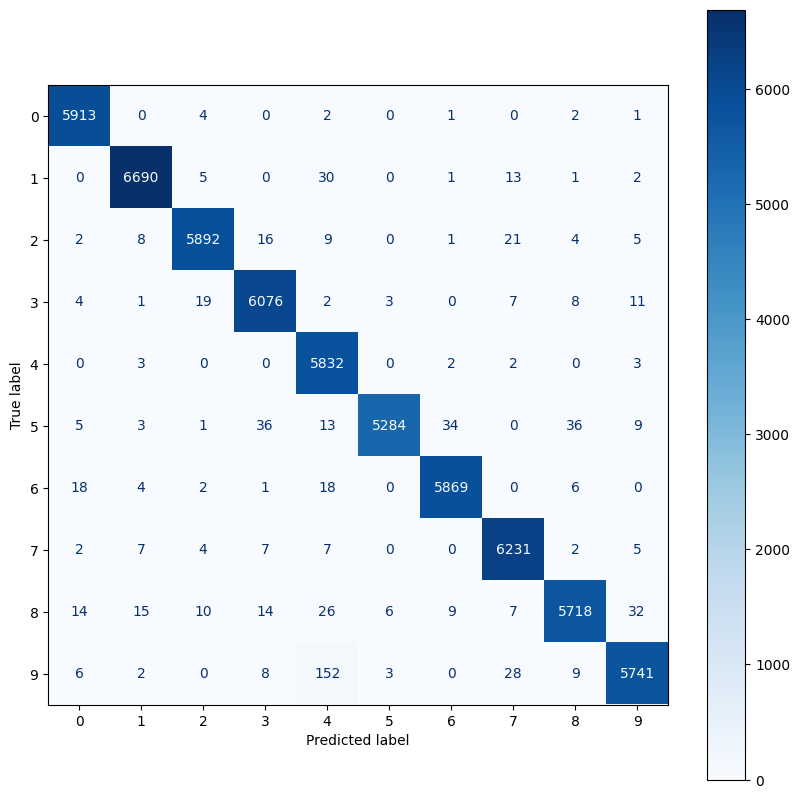

In [14]:
# 用測試資料集，檢查一下 MLP 模型效能
test_loss, test_acc = evaluate(modelCNN, test_loader, criterion_CNN, device)

print('測試集結果：', test_acc)

# 從測試集中，來檢查每個分類的正確程度
images, labels, probs = predict(modelCNN, test_loader, device)

pred_labels = torch.argmax(probs, 1)

# 把結果用 confusion matrix 形式畫出來
plot_confusion_matrix(labels, pred_labels)

## 評估 -- 使用 tensorboard

注意事項

*   在 colab 上使用 tensorboard：須允許 cookie 存取
*   在其他平台上使用 tensorboard：它會在執行主機上的特定連接埠（預設 6006）建立網頁服務


---

**Quiz - 3 : 開啟 tensorboard 介面，觀察以上兩個模型的學習曲線（learning curve），請問你認為、以上模型哪一個可以開始拿來用？（用來預測圖片中的數字）**



In [15]:
# 執行 tensorboard 讀取 log 目錄下的記錄
LOG_DIR = './runsmlp' # runsmlp, runscnn
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

In [16]:
from tensorboard import notebook
notebook.list() # View open TensorBoard instances

No known TensorBoard instances running.


In [17]:
# 在 colab 連上之前建立的 tensorboard 資料
# the most recently launched TensorBoard is used
notebook.display(port=6006, height=1000)

<IPython.core.display.Javascript object>

In [18]:
notebook.display(port=6008, height=1000)

<IPython.core.display.Javascript object>

## 評估 -- 使用 confusion matrix

In [ ]:
# 展示一個混淆矩陣（confusion matrix）來檢討結果
def plot_confusion_matrix(labels, pred_labels):

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    cm = metrics.confusion_matrix(labels, pred_labels)
    cm = metrics.ConfusionMatrixDisplay(cm, display_labels=range(10))
    cm.plot(values_format='d', cmap='Blues', ax=ax)

In [ ]:
# 把 MLP 模型測試結果用 confusion matrix 形式畫出來
plot_confusion_matrix(labels, pred_labels)

In [ ]:
# 把 CNN 模型測試結果用 confusion matrix 形式畫出來
plot_confusion_matrix(labels, pred_labels)